# NBA game Prediction with Logistic Regression based on ELO score and lineup-changes

## Introduction

How do you rate NBA teams across decades of plays? There are many popular methodologies utilized to evaluate all respectives of a team, trying to predict a reasonable result based on their historical performances.In the meantime, there are also many data sets describing the performances of NBA teams as well as individual players features, from which analysts are constantly trying to seek a concrete yet keen model, enabling them to understand the correlations in between. 

In this project, we will be using NBA data from <a href="www.basketball-reference.com">www.basketball-reference.com</a> which provides a comprehensive dataset describing NBA games. We will apply one of the popular analyzing method - [Elo Ranking Score](https://en.wikipedia.org/wiki/Elo_rating_system) to process and predict a comparative pairwise win-loss states, validate its feasibility, accuracy, and raise questions especailly on reasons for the discripancies. We will address those factors and their walkarounds methods, essentially how we are able to tuning the original model, and how effective that can be. 

Among all, Elo remains to be a simple measure of strength based on game-by-game results. Elo Ratings indicated a simple goal: to provide an objective and reliable measure by which the strength of two opponents can be compared. 

The Elo rating system is a method for calculating the relative skill levels of players in competitor-versus-competitor games such as basketball. Some essentials behind using Elo in analyzing NBA games in regular season is that:
1. <b>Simplicity</b> - the ratings depend only on the final score of each game and where it was played (home-court advantage)
2. <b>The K-factor</b> - Elo’s K-factor determines how quickly the rating reacts to new game results. We found the optimal K for the NBA to be around 20.

Using the data from the former two years to train the Elo model, we are able to predict the upcoming game result. However, the discrepancies are still noticably high. A major issue that we did not take into account was the team lineup are constantly changing. The core problems that this analytical model should resolve are: How these changes had impacted our model and how possible a walkaround is able to fix it. 

The second part of this project entails a series of calculations and trainings, trying to identify the team players who have a significant impact on the team performance, and then extract their features and factor them into the Logistic Regression prediction model. 


## Project Outline

In this project, we have constructed a complete data science pipeline to help us to reach the final conclusion. Specifically, this piepline includes five major components, such as data collection, data preprocessing, data visualization, prediction and conclusion. The detailed outline for this report is shown below:

- [Data Collection](#Data Collection)
- [Data Preprocessing](#Data Preprocessing)
- [Data visualization](#Data Visualization)
- [Prediction](#Prediction)
  - [Prediction with Elo score](#Prediction with Elo score)
  - [Prediction in consideration of lineup changes](#Prediction in consideration of lineup changes)
- [Conclusion](#Conclusion)

## Import Libraries

In [1]:
import pandas as pd
import math
import os
import csv
import random
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
from functools import reduce

## Data Collection

In order to predict the team performance, we select the typical basketball used data related with each team, which means all the data is team specific and they are averaged throughout the 82 games in each NBA regular season. Note that all the data comes from one single data source: [basketball reference](https://www.basketball-reference.com/). It is very convenient to use this website for this project is that you can either downlaod them one by one as <b>CSV file</b>, or if there are multiple number of files, we can use a web crawler to scrape the data. In the case of this project, we utilize both apporaches to get the data we need. The data source and the ways to get them are listed below, they are all in the <b>data</b> directory.

For each season ranging from 10-11 to 17-18
1. Team_Per_Game_Stat data set(contains the game-average data for all normal stats used in basketball, such as Field Goal Attempt, Field Goal Percentage, Rebounds and so on.) -> <b>Download</b>

2. Opponent_Per_Game_Stat data set(the average opponent's team performance when matched with this team, the categories of the data are the same as the ones in Team_Per_Game_Stat data set.) -> <b>Download</b>

3. Miscellaneous_Stat data set(other stats such as average ages of one team, the number of winning games and losing games and so on.) -> <b>Download</b>

4. Result data set(82 game match up results) -> <b>Download</b>

5. Player Advanced stats(inlcuding PER, DWS(Defensive win share), OWS(Offensive win share) and so on) from season 17-18 for four typical teams: Cleveland_Cavaliers, Golden_State_Warriors, Oklahoma_City_Thunder, Houston_Rockets -> <b>Download</b>

6. The changes of players for each team between two seasons(the relevant categories: Minutes Played, PER, OWS, DWS and so on) -> <b>the web crawler</b>

The code for web crawler is shown below:

In [2]:
base_url = "https://www.basketball-reference.com/teams"
data_dir = 'data/advanced'
team_list = ['TOR', 'BOS', 'PHI', 'CLE', 'IND', 'MIA', 'MIL', 
             'WAS', 'DET', 'CHO', 'NYK', 'BRK', 'CHI', 'ORL',
             'ATL', 'HOU', 'GSW', 'POR', 'OKC', 'UTA', 'NOP',
             'SAS', 'MIN', 'DEN', 'LAC', 'LAL', 'SAC', 'DAL',
             'MEM', 'PHO']
regex = {}
regex['Name'] = re.compile(r'<a.*?\.html">([\w\s\.\'\-,]+?)</a>')
regex['PER'] = re.compile(r'data-stat="per" >([-\d\.]*?)</td>')
regex['OWS'] = re.compile(r'data-stat="ows" >([-\d\.]+?)</td>')
regex['DWS'] = re.compile(r'data-stat="dws" >([-\d\.]+?)</td>')
regex['OBPM'] = re.compile(r'data-stat="obpm" >([-\d\.]+?)</td>')
regex['DBPM'] = re.compile(r'data-stat="dbpm" >([-\d\.]+?)</td>')
regex['MP'] = re.compile(r'data-stat="mp" >([-\d\.]+?)</td>')
regex['VORP'] = re.compile(r'data-stat="vorp" >([-\d\.]+?)</td>')
regex['AGE'] = re.compile(r'data-stat="age" >([-\d\.]+?)</td>')
regex['TS'] = re.compile(r'data-stat="ts_pct" >([-\d\.]*?)</td>')
regex['3PAr'] = re.compile(r'data-stat="fg3a_per_fga_pct" >([-\d\.]*?)</td>')
regex['FTr'] = re.compile(r'data-stat="fta_per_fga_pct" >([-\d\.]*?)</td>')
regex['USG'] = re.compile(r'data-stat="usg_pct" >([-\d\.]*?)</td>')
regex['BPM'] = re.compile(r'data-stat="bpm" >([-\d\.]+?)</td>')

In [3]:
def get_advanced_data(team, year):
    if team == 'CHO' and year <= 2014:
        url = "{}/{}/{}.html".format(base_url, 'CHA', year)
    elif team == 'BRK' and year <= 2012: 
        url = "{}/{}/{}.html".format(base_url, 'NJN', year)
    elif team == 'NOP' and year <= 2013:
        url = "{}/{}/{}.html".format(base_url, 'NOH', year)
    else:
        url = "{}/{}/{}.html".format(base_url, team, year)
    
    response = requests.get(url)
    root = BeautifulSoup(response.text, "html.parser")
    advanced_text = str(root.find(id="all_advanced"))
    
    data = {}
    for feature, reg in regex.items():
        data[feature] = reg.findall(advanced_text)
#         if feature == 'Name':
#             print(data[feature])
#         # added for some special case
        if feature != "Name":
            data[feature] = [i if i else '0' for i in data[feature]]
#         print(len(data[feature]))
    
    df = pd.DataFrame.from_dict(data).set_index('Name').astype("float")
    df['Norm_OWS'] = (df['OWS'] - df['OWS'].min()) / (df['OWS'].max() - df['OWS'].min())
    df['Norm_DWS'] = (df['DWS'] - df['DWS'].min()) / (df['DWS'].max() - df['DWS'].min())
    df['Team'] = team
    
    csv_path = "{}/{}_{}.csv".format(data_dir, team, year)
    df.to_csv(csv_path, encoding = 'utf8')

To download all the necessary data

In [4]:
# get the data for each team lineups from 2010 and 2018
for y in range(2010, 2019):
    print(y)
    for t in team_list:
        try:
            get_advanced_data(t, y)
        except:
            print('error happend when extract player info in ' + t + ' in ' + str(y))
            print(t)

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [5]:
T_data = pd.read_csv(os.path.join("data", "10-11", 'Team_Per_Game_Stat_raw.csv'))
O_data = pd.read_csv(os.path.join("data", "10-11", 'Opponent_Per_Game_Stat_raw.csv'))
M_data = pd.read_csv(os.path.join("data", "10-11", 'Miscellaneous_Stat_raw.csv'))
R_data = pd.read_csv(os.path.join("data", "10-11", 'Result_raw.csv'))
TOR_14 = pd.read_csv("{}/TOR_2014.csv".format(data_dir)).set_index("Name")

In [6]:
print("T_data's data categories:")
print(list(T_data.columns))
print("O_data's data categories:")
print(list(O_data.columns))
print("M_data's data categories:")
print(list(M_data.columns))
print("R_data's data categories:")
print(list(R_data.columns))
print("TOR_14's data categories:")
print(list(TOR_14.columns))

T_data's data categories:
['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
O_data's data categories:
['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
M_data's data categories:
['Rk', 'Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1', 'TOV%.1', 'DRB%', 'FT/FGA.1', 'Arena', 'Attend.', 'Attend./G']
R_data's data categories:
['Date', 'Start (ET)', 'Visitor/Neutral', 'PTS', 'Home/Neutral', 'PTS.1', 'Unnamed: 6', 'Unnamed: 7', 'Attend.', 'Notes']
TOR_14's data categories:
['3PAr', 'AGE', 'BPM', 'DBPM', 'DWS', 'FTr', 'MP', 'OBPM', 'OWS', 'PER', 'TS', 'USG', 'VORP', 'Norm_OWS', 'Norm_DWS', 'Team']


## Data Preprocessing

After we collect all relevant data, the first thing we need to do is to preprocess the data so that it can be used in the following visualizations and calculations. We have defined a raw data handler class in python to specifically achieve those tasks. There are three things that we want to achieve with this class: 

First, standardize all the team name so that all correlated data can be referenced correctly and we can use team name as an input argument to reference and fetch those data. Second, transform the result data set into the a more direct win/lose relationship between the home team and the visiting team. As you can see from the output in the previous cell, the categories of data in the result data set only show the points of home team and visiting team. So we want to transform this data set into the one that contains three columns: <b>visitor team/home team/V</b>(means visitor team wins), <b>home team/visitor team/H</b>(means home team wins). We do this because we want to utilize the win/lose relationship more easily in the following prediction. Third, we want to create a schedule data set with only <b>Visitor Team</b>/<b>Home Team</b> also for the purpose of prediction calculation in the following phase. All the preprocessed data will be saved as CSV file in the same directory as the raw data but with different filenames. The code are shown below with comments to specify the functionalities:

In [7]:
class raw_data_handler:
    data_dir = "data"
    team_dict = {'Utah': 'Utah Jazz', 'Memphis': 'Memphis Grizzlies', 'San Antonio': 'San Antonio Spurs',
        'Indiana': 'Indiana Pacers', 'Atlanta': 'Atlanta Hawks', 'Miami': 'Miami Heat',
        'Charlotte': 'Charlotte Hornets', 'Milwaukee': 'Milwaukee Bucks', 'Chicago': 'Chicago Bulls',
        'Washington': 'Washington Wizards', 'Portland Trail': 'Portland Trail Blazers',
        'New Orleans': 'New Orleans Pelicans', 'Cleveland': 'Cleveland Cavaliers', 'Detroit': 'Detroit Pistons',
        'Golden State': 'Golden State Warriors', 'Los Angeles C': 'Los Angeles Clippers', 
        'Houston': 'Houston Rockets', 'Brooklyn': 'Brooklyn Nets', 'Toronto': 'Toronto Raptors',
        'Philadelphia': 'Philadelphia 76ers', 'New York': 'New York Knicks', 'Boston': 'Boston Celtics',
        'Orlando': 'Orlando Magic', 'Oklahoma City': 'Oklahoma City Thunder', 'Dallas': 'Dallas Mavericks',
        'Phoenix': 'Phoenix Suns', 'Denver': 'Denver Nuggets', 'Sacramento': 'Sacramento Kings',
        'Los Angeles L': 'Los Angeles Lakers', 'Minnesota': 'Minnesota Timberwolves', 
        'New Jersey':'Brooklyn Nets',
        }
    raw_result = 'Result_raw.csv'
    raw_dict = {'Mstat' : 'Miscellaneous_Stat_raw.csv',
                'Ostat' : 'Opponent_Per_Game_Stat_raw.csv',
                'Tstat' : 'Team_Per_Game_Stat_raw.csv'}
    csv_dict = {'Mstat': 'Miscellaneous_Stat.csv',
                'Ostat': 'Opponent_Per_Game_Stat.csv',
                'Tstat': 'Team_Per_Game_Stat.csv'}
    
    def get_team(self, row):
        """the function for normalizing the team name
            Args: 
                (String): the uncleaned team name
            Returns: 
                (String) : the standardized team name
        """
        # handle the Los Angeles Lakers and Los Angeles Clippers
        if 'Los' in row:
            team = row[:13]
        else:
            team = ' '.join(row.split(" ")[:-1])
        return self.team_dict.get(team, np.nan)
  
    def create_csv(self, df, csv_name, season):
        """this is the helper function for creating the csv file on
           the specified directory.
           Args:
                (dataframe) df: the dataframe that contains the data
                (String) csv_name: csv file name
                (String) season: the season number, such as "10-11"          
        """
        csv_path = os.path.join(self.data_dir, season, csv_name)
        df.to_csv(csv_path, encoding = 'utf8', index = False)
    
    def create_result_csv(self, df, season):
        """this is the helper function for creating the csv file for result on
           the specified directory.
           
           Compare the score of home team and visiting team to determine the whether
           the winning team is home team(labeld as H) or visiting team(labeled as V)
           write the results into the data frame.
           Args:
               (dataframe) df: the dataframe that contains the data
               (String) season: the season number, such as "10-11"
        """
        result_path = os.path.join(self.data_dir, season, 'Result.csv')
        data = []
        for index, row in df.iterrows():
            data.append([row['Visitor/Neutral'], row['Home/Neutral'], 'V'] 
                        if row['PTS'] > row['PTS.1'] else [row['Home/Neutral'], row['Visitor/Neutral'], 'H'])
        with open(result_path, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['WTeam', 'LTeam', 'WLoc'])
            writer.writerows(data)
    
    def norm_store_stat(self, stat_name, season):
        """this is the helper function for normalize stat data.
           
           This function mainly standardize the team name for the input data set
           and remove all NaN data.
           Args:
               (String) stat_name: the name of the data set.
               (String) season: the season number, such as "10-11"
        """
        stat = pd.read_csv(os.path.join(self.data_dir, season, self.raw_dict[stat_name]))
        stat['Team'] = stat['Team'].apply(self.get_team)
        self.create_csv(stat.dropna(), self.csv_dict[stat_name], season)
    
    def run(self, season_num):
        """this is the main function to preprocess all four data sets
           (Team_Per_Game_Stat_raw.csv, Opponent_Per_Game_Stat_raw.csv,
            Miscellaneous_Stat_raw.csv, Result_raw.csv)
           given the season number.
           Args:
               (String) season_num: the season number of the data
        """
        season = "{}-{}".format(season_num, season_num + 1)
        
        # read and normalize the team name in Rstat
        Rstat = pd.read_csv(os.path.join(self.data_dir, season, self.raw_result))
        Rstat['Visitor/Neutral'] = Rstat['Visitor/Neutral'].apply(self.get_team)
        Rstat['Home/Neutral'] = Rstat['Home/Neutral'].apply(self.get_team)
        # create the result file
        self.create_result_csv(Rstat, season)
        
        # create the schedule file
        self.create_csv(Rstat.loc[:,['Visitor/Neutral', 'Home/Neutral']], 
                        'Schedule.csv', season)
        
        # read, standardize and store the Mstat
        self.norm_store_stat('Mstat', season)
        
        # read, standardize and store the Ostat
        self.norm_store_stat('Ostat', season)
        
        # read, standardize and store the Tstat
        self.norm_store_stat('Tstat', season)
         

Preprocess all the data for 10-11 regular season to 17-18 regular season using our implemented raw_data_handler:

In [8]:
# set up the raw data handler class
data_handler = raw_data_handler()
# preprocess all the data ranging from 10-11 to 17-18 season
for sea_num in range(10, 18):
    data_handler.run(sea_num)

To verify that data is correctly preprocessed for result and schedule, read the data in 10-11 regular season:

In [9]:
R_P_data = pd.read_csv(os.path.join("data", "10-11", 'Result.csv'))
S_data = pd.read_csv(os.path.join("data", "10-11", 'Schedule.csv'))
print("The columns in preprocessed result data set:")
print(list(R_P_data))
print("The columns in schedule data set:")
print(list(S_data))

The columns in preprocessed result data set:
['WTeam', 'LTeam', 'WLoc']
The columns in schedule data set:
['Visitor/Neutral', 'Home/Neutral']


## Data Visualization

After the data is cleaned and preprocessed, we want to get more deep view inside the data so that we can if there are any features that are rather different from others. More importantly, we want to see that how different that a player can influence their team performance when compared with other team members in the same team. 

Therefore, the visualization for the data can be divided into two parts:
 1. A simple visualization on one team's performance, such as Field Goal Percentage, Points(averaged each game).    
 2. Visualization of the individual players' performances for the following four NBA teams as an example here:
- Cleveland_Cavaliers
- Golden_State_Warriors
- Houston_Rockets
- Oklahoma_City_Thunder

Data will be collected for them from 17-18 season and we will have each players' OWS, DWS plotted in a scatter plot.

In [10]:
def plot_bar_graph(df, feature):
    """plot the one feature across all 30 NBA teams
        Args:
            (dataframe) df: the data frame to use
            (String) feature: the feature to be plotted
    """
    bar_width = 0.8
    teams = list(df['Team'])
    y_vals = list(df[feature])
    index = np.arange(len(teams))
    plt.barh(index, y_vals, bar_width)
    plt.ylabel('Team Name', fontsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.yticks(index, teams, fontsize=15, rotation=30)
    plt.rcParams["figure.figsize"] = [20, 9]
    plt.show()

Plot all teams' field goal percentage:

In [13]:
T_data = pd.read_csv(os.path.join("data", "10-11", 'Team_Per_Game_Stat.csv'))
# plot_bar_graph(T_data, 'FG%')

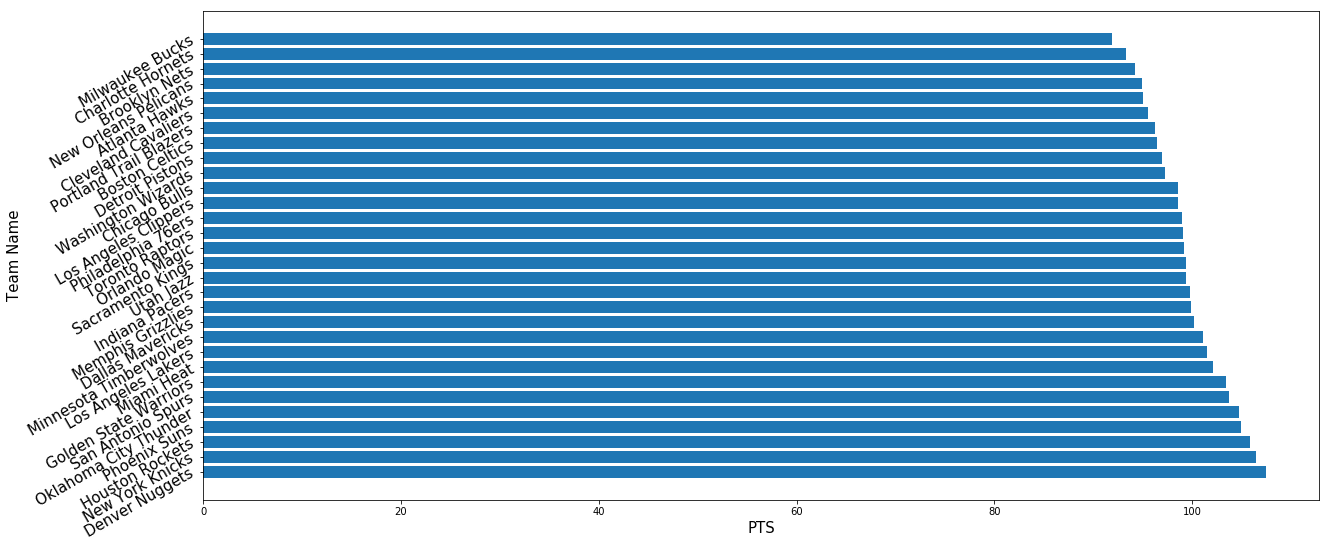

In [14]:
plot_bar_graph(T_data, 'PTS')

In this second part, we will be emphasizing on individual contributions to teams. In specific we will evaluate the contribution from the metrics below:
- <b>Offensive Win Shares (OWS)</b>: A metric that estimates the number of wins a player produces for his team due to his offensive ability. 
- <b>Defensive Win Shares (DWS)</b>: A metric that estimates the number of wins a player produces for his team due to his defensive ability. 
- <b>Player Efficiency Rating (PER)</b>: sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance

The purpose of this part is to plot the relativity performances of each player in terms of the above three aspects within a group. The time frame will be on seasonal base. 

In [15]:
def read_advanced_data(season_num, team_name):
    """
    First we will load the data into our pandas dataframe. 

    After loading the data, it is important, since we are going to include three different perameters in the same plot,
    that we normalize them to be of the same scale.
    
    Args: season_num - the season starting point year in two digit format, the function will match with the data source 
                        file format.
          team_name - the one of the four teams of interests           
          Concatenate these features to locate the data file to load
    Returns: 
          Processed dataframe containing the input perameters after normalization: normalized OWS, normalized DWS 
          and normalized PER for the team of interest for a certain year
    
    """
    season = "{}-{}".format(season_num, season_num + 1)
    advanced = pd.read_csv(os.path.join("data", season, team_name, 'Advanced.csv'), index_col = 1)
    advanced.index = advanced.index.map(lambda x: x.split('\\')[0])
    advanced = advanced[advanced['PER'] > 0]
    advanced['norm_OWS'] = (advanced['OWS'] - advanced['OWS'].min()) / (advanced['OWS'].max() - advanced['OWS'].min())
    advanced['norm_DWS'] = (advanced['DWS'] - advanced['DWS'].min()) / (advanced['DWS'].max() - advanced['DWS'].min())
    advanced['norm_PER'] = (advanced['PER'] - advanced['PER'].min()) / (advanced['PER'].max() - advanced['PER'].min())
    
    return advanced[['norm_OWS', 'norm_DWS', 'norm_PER']]

In [16]:
def plot_team_player(df):
    """
    We will be using matplotlib's scatter plot to display the relativity strength of OWS horizontally 
    and DWS vertically, in the meantime, since PER represents a relative strength of each player. 
    We will showcase this degree of strength using the are of the plot.
    
    Args: dataframe of the measuring perameters read from the files containing normalized
         OWS, DWS and PER. 
         
    Return: Matplot scatter plot object displays the relativity of all team members, the 
            result should indentify the performance of each player within their team.
            
    """
    
    # x represents the player offense stat
    X = df['norm_OWS'].values
    
    # y represents the player defense stat
    Y = df['norm_DWS'].values
   
    # area represents the player efficiency rate, The marker size in points**2.
    # 400 is to increase the general scale of each point. 
    area = df['norm_PER'] ** 2 * 400
    
    # Define the bench mark to differentiate significant players - whose scores for these three
    # perameters are far beyond average players
    mid_area = area.max() * 0.3
    mid_x = X.max() * 0.5
    mid_y = Y.max() * 0.5
    colors = np.random.rand(df.shape[0])
    
    fig = plt.figure(figsize=(8,6), dpi=100)
    plt.xlabel('OWS')
    plt.ylabel('DWS')
    plt.scatter(X, Y, s = area, c = colors, alpha = 0.5)
    
    # Add labels to identify key players
    for label, x, y, s in zip(df.index, X, Y, area):
        if s < mid_area and x < mid_x and y < mid_y:
            continue
        plt.annotate(
            label,
            xy=(x, y), xytext=(0, 100),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='none', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()

# https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate

Next, we can use the above functions to plot the four teams for the year of 2017 to 2018.

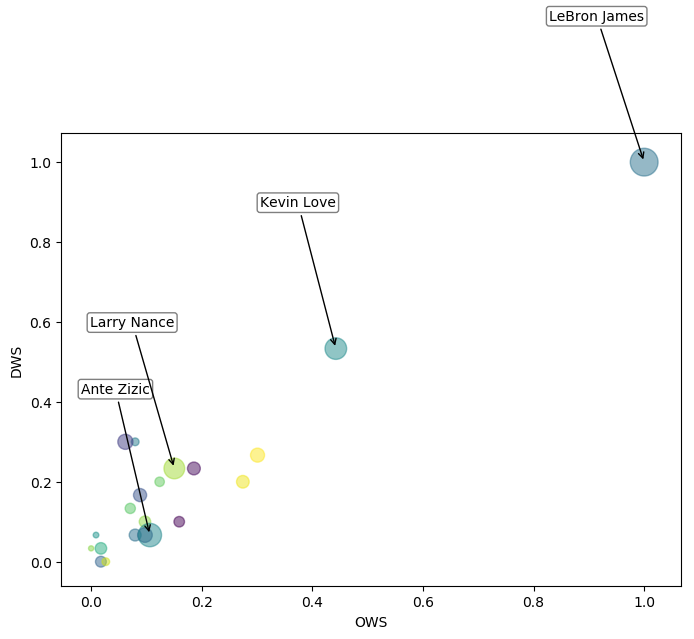

In [17]:
df = read_advanced_data(17, 'Cleveland_Cavaliers')
plot_team_player(df)

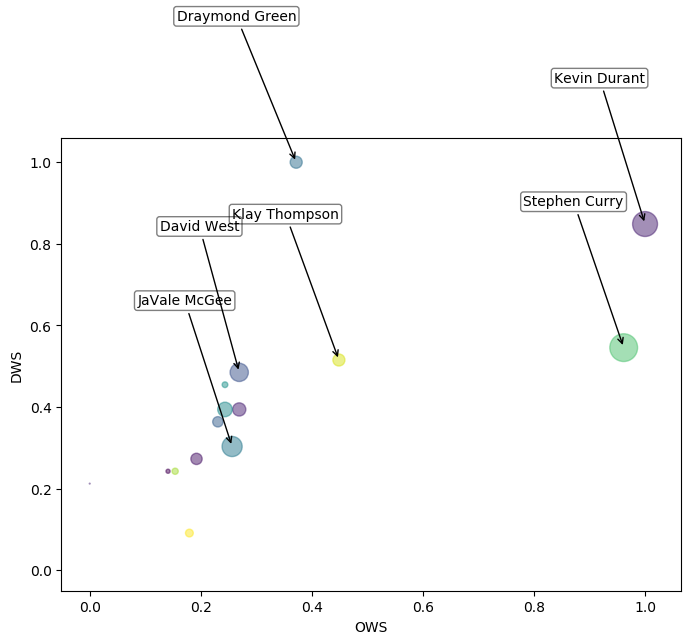

In [18]:
df = read_advanced_data(17, 'Golden_State_Warriors')
plot_team_player(df)

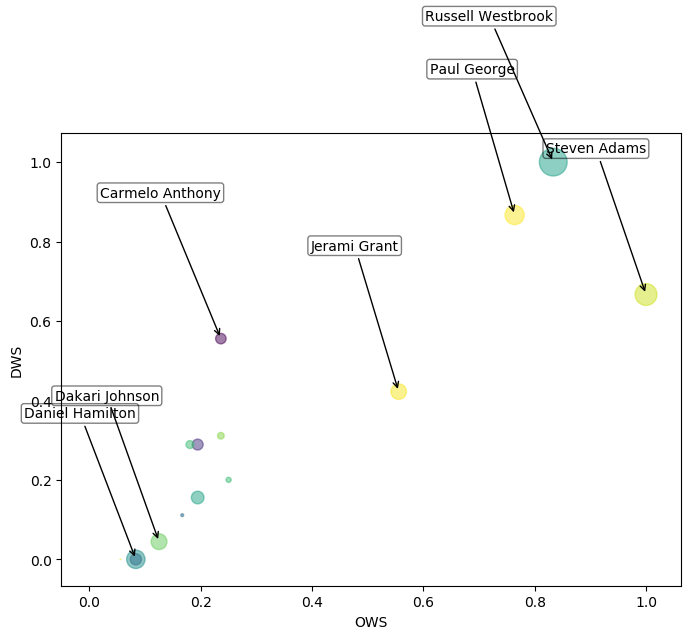

In [19]:
df = read_advanced_data(17, 'Oklahoma_City_Thunder')
plot_team_player(df)

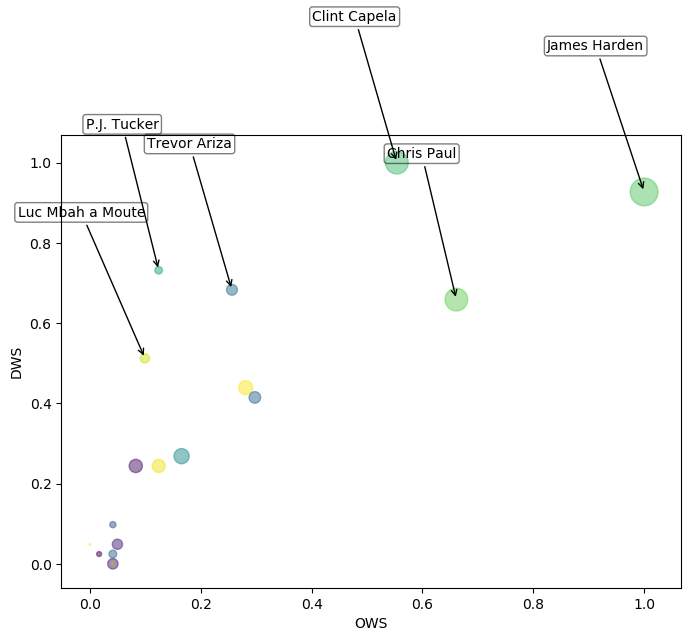

In [20]:
df = read_advanced_data(17, 'Houston_Rockets')
plot_team_player(df)

## Prediction

After the visulization of the data, we can clearly see that some player's performance is exceptionally well when compared with other players, thus possibly impacting the team performance. In this section, we will present two predictions here. 
- First, we will only use the team performance to train the model and predict the match up results for next year. 
- Then, in the second prediction, we will use both the team performance and the performance of players who have left and came to the team to train the model and predict the results. 

Last, we will compare those two methods and get a conclusion. Before that, we need to define two functions since they are used in both predictions:
- function to load the team performance data
- function to check the accuracy of the predictions. 


In [21]:
def load_stat(season):
    """the function to load team performance stats for specific one season.
       Args:
           (int) season: the season number
       Return:
           (dataframe) the dataframe contains the data frame
    """
    print("create team stat features for ", season)
    Mstat = pd.read_csv(os.path.join('data', season, 'Miscellaneous_Stat.csv')).drop(['Rk', 'Arena'], axis=1)
    Ostat = pd.read_csv(os.path.join('data', season, 'Opponent_Per_Game_Stat.csv')).drop(['Rk', 'G', 'MP'], axis=1)
    Tstat = pd.read_csv(os.path.join('data', season, 'Team_Per_Game_Stat.csv')).drop(['Rk', 'G', 'MP'], axis=1)
    team_stats = Mstat.merge(Ostat, how='left', on='Team').merge(Tstat, how='left', on='Team')
    return team_stats.set_index('Team', inplace=False, drop=True)

In [22]:
def check_accuracy(result, next_season, store_filename):
    """check the accuracy of the predict result against the true match result
       Args:
           (result) result: the dataframe containing the predicted result
           (int) next_season: next_season number
           (string) store_filename: the filename for storing the accuracy results
    """
    with open(os.path.join('data', next_season, 'Result.csv')) as f:
        true_result = list(map(lambda x: x.split(',')[0:-1], f.readlines()))[1:len(result)+1]
        conf = [0.5, 0.6, 0.7, 0.8, 0.9]
        error = dict([(i, 0) for i in conf])
        # create the columns of the accuracy dataframe
        columns = np.append(np.array(['{}/mis_W {}/mis_L'.format(i, i).split(' ') for i in conf]).flatten(), ['pred_W', 'pred_L', 'true_W', 'true_L'])
        # initialize the accuracy dataframe
        team_stat = pd.DataFrame(data = 0, index = team_set, columns = columns)
        # for each match, update the accuracy dataframe with the true and pred result
        for t, p in zip(true_result, result):
            team_stat.loc[p[0], 'pred_W'] += 1
            team_stat.loc[p[1], 'pred_L'] += 1
            team_stat.loc[t[0], 'true_W'] += 1
            team_stat.loc[t[1], 'true_L'] += 1
            # pred winner doesn't match the true result
            if t[0] != p[0]:
                # update each error number
                for i in error:
                    if p[2] >= i and p[2] < (i+0.1):
                        error[i] += 1
                        team_stat.loc[p[0], '{}/mis_W'.format(i)] += 1
                        team_stat.loc[p[1], '{}/mis_L'.format(i)] += 1
        
        team_stat['W_L_delta'] = team_stat['true_W'] - team_stat['pred_W']
        team_stat['abs_W_L_delta'] = team_stat['W_L_delta'].abs()
        # store the accuracy calculation
        team_stat.to_csv(os.path.join('data', next_season, store_filename))
        for i in error:
            pred_num = len(list(filter(lambda x: i <= x[2] < (i+0.1), result)))
            print('{} confidence:, total num: {}, error num: {}'.format(i*100, pred_num, error[i]))
            if error[i] > 0:
                print("error_rate: ", error[i]/pred_num)
        
        print("total error rate: {}".format(sum(error.values()) / len(result)))
        print("Win Los delta avg: {}, var: {}".format(team_stat['abs_W_L_delta'].mean(), team_stat['abs_W_L_delta'].var()))

In [23]:
# all nba teams:
"""
Global Variable: The names of all NBA team are also set up as a global variable here. 

"""
team_dict = {'Utah': 'Utah Jazz', 'Memphis': 'Memphis Grizzlies', 'San Antonio': 'San Antonio Spurs',
        'Indiana': 'Indiana Pacers', 'Atlanta': 'Atlanta Hawks', 'Miami': 'Miami Heat',
        'Charlotte': 'Charlotte Hornets', 'Milwaukee': 'Milwaukee Bucks', 'Chicago': 'Chicago Bulls',
        'Washington': 'Washington Wizards', 'Portland Trail': 'Portland Trail Blazers',
        'New Orleans': 'New Orleans Pelicans', 'Cleveland': 'Cleveland Cavaliers', 'Detroit': 'Detroit Pistons',
        'Golden State': 'Golden State Warriors', 'Los Angeles C': 'Los Angeles Clippers', 
        'Houston': 'Houston Rockets', 'Brooklyn': 'Brooklyn Nets', 'Toronto': 'Toronto Raptors',
        'Philadelphia': 'Philadelphia 76ers', 'New York': 'New York Knicks', 'Boston': 'Boston Celtics',
        'Orlando': 'Orlando Magic', 'Oklahoma City': 'Oklahoma City Thunder', 'Dallas': 'Dallas Mavericks',
        'Phoenix': 'Phoenix Suns', 'Denver': 'Denver Nuggets', 'Sacramento': 'Sacramento Kings',
        'Los Angeles L': 'Los Angeles Lakers', 'Minnesota': 'Minnesota Timberwolves', 
        'New Jersey':'Brooklyn Nets',
        }
team_set = sorted(list(set(team_dict.values())))

### Prediction with Elo score

Now with the common functions defined, we are able to build a Logestic Regression training model using the team performance to predict the match up result for upcoming year. This process can be describe as the following: 
- First, all the data related to the team performance are merge as one numpy 2d array as both training and test data set. 
- Second, calculate the elo_score based on the match up result of current season utilizing the <a href="https://en.wikipedia.org/wiki/Elo_rating_system">ELO Score Function</a>(Link to check the Mathematical Details). 
- Third, predict the probablity of all match up results(win/lose) for the next season based on schedule of next season. All the codes are wrapped up as one class for easy usage and they are shown below:

In [24]:
class team_win_lose_predictor:    
    base_elo = 1600
    
    def get_model(self, season_num):
        """train and cross validate the logistic regression using the team performance data
           incorporated with lineup changes.
           Args:
               (int) season_num: the season number
           Returns:
               (model) model: already trained logistic model
        """
        season = "{}-{}".format(season_num, season_num + 1)
        # load all the data
        Rstat = pd.read_csv(os.path.join('data', season, 'Result.csv'))
        self.team_stats = load_stat(season)
        
        #initialize the elo score with base elo
        self.team_elos = dict([(i, self.base_elo) for i in team_set])
        
        # create training features and result
        X, y = self.build_dataset(Rstat)
        print("Fitting on %d game samples.." % len(X))
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        
        print("Doing cross-validation..")
        print(cross_val_score(model, X, y, cv = 10, scoring='accuracy', n_jobs=-1).mean())
        
        return model
    
    def calc_elo(self, win_team, lose_team):
        """
        Calculate and update the elo value for the given teams' previous year's performances 
        and their win-lose relationship in the training model.
    
        Args: win_team - the prior year's winner feature Pandas Series to exact elo data
              lose_team - the prior year loser team feature Pandas Series to exact elo data
        
        Returns:
             a tuple of: calculated winning team's elo score, 
                         calculated losing team's elo score              
        """
        # load the original elos of the two teams
        winner_rank = self.team_elos[win_team]
        loser_rank = self.team_elos[lose_team]
        
        rank_diff = winner_rank - loser_rank
        
        # Recalculate the expected score of Loser Team
        odds = 1 / (1 + 10 ** (-rank_diff / 400))
        
        # Taking into account the k factor:
        if winner_rank < 2100:
            k = 32
        elif winner_rank >= 2100 and winner_rank < 2400:
            k = 24
        else:
            k = 16
        
        # Supposing Winner Team was expected to score an elo of winner_rank points 
        # but actually scored points different by odds times . 
        # The formula for updating their rating is:
        new_winner_rank = round(winner_rank + (k * (1 - odds)))
        new_loser_rank = loser_rank + winner_rank - new_winner_rank
        
        return new_winner_rank, new_loser_rank
    
    # 
    def build_dataset(self, raw_data):
        """
        Build the training dataset based on the raw data
        
        Args: raw_data - load the actual result dataframe of the game.
        """
        print("Building dataset ...")
        
        X = []
        y = []
        
        for index, row in raw_data.iterrows():
            Wteam = row['WTeam']
            Lteam = row['LTeam']
            # get the elos of the two teams
            team1_elo = self.team_elos[Wteam]
            team2_elo = self.team_elos[Lteam]
            # update the elo value
            if row['WLoc'] == 'H':
                team1_elo += 100
            else:
                team2_elo += 100
            # add elo value into the feature
            team1_features = [team1_elo]
            team2_features = [team2_elo]
            # add Tstat, Ostat and Mstat into the feature
            for key, value in self.team_stats.loc[Wteam].iteritems():
                team1_features.append(value)
            for key, value in self.team_stats.loc[Lteam].iteritems():
                team2_features.append(value)

            # randomize the feature and label
            if random.random() > 0.5:
                X.append(team1_features + team2_features + [1])
                y.append(0)
            else:
                X.append(team2_features + team1_features + [1])
                y.append(1)

            new_winner_rank, new_loser_rank = self.calc_elo(Wteam, Lteam)
            self.team_elos[Wteam] = new_winner_rank
            self.team_elos[Lteam] = new_loser_rank
        
        return np.nan_to_num(X), y
    
    
    def predict_winner(self, team_1, team_2, model):
        """
        Predict the winner of a match
        Args: team_1: the visiting team Data Series
              team_2: the Home team Data Series
              model:  the trained Logestic Regression model
        Returns:
              The predicted probability of one match-up game.
        """
        features = []
        features.append(self.team_elos[team_1])
        for key, value in self.team_stats.loc[team_1].iteritems():
            features.append(value)
        features.append(self.team_elos[team_2] + 100)
        for key, value in self.team_stats.loc[team_2].iteritems():
            features.append(value)
        features.append(1)
        features = np.nan_to_num(features)
        return model.predict_proba([features])
    
    def predict_schedule(self, schedule, model):
        """
        Predict the win-lose relationship with the given schedule
        Args: schedule - the loaded csv of schedule
              model - the trained Logestic Regression model
        
        Return: The predicted match-up result per the given schedule. 
        """
        result = []
        for index, row in schedule.iterrows():
            team1 = row['Visitor/Neutral']
            team2 = row['Home/Neutral']
            pred = self.predict_winner(team1, team2, model)
            prob = pred[0][0]
            item = [team1, team2, prob] if prob > 0.5 else [team2, team1, 1 - prob]
            result.append(item)
        return result
    
    # run the predict
    def run(self, season_num):
        """
        Run the predict
        Args: season_num - user's input of the year to be predited      
        """
        model = self.get_model(season_num)
        next_season = "{}-{}".format(season_num + 1, season_num + 2)
        schedule = pd.read_csv(os.path.join('data', next_season, 'Schedule.csv'))
        result = self.predict_schedule(schedule, model)

        with open(os.path.join('data', next_season, 'Pre_Result.csv'), 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['win', 'lose', 'probability'])
            writer.writerows(result)
            print('done.')
        
        check_accuracy(result, next_season, "Team_stat_Accu.csv")

Run the predictor for all seasons from 10-11 to 16-17 seasons and show the accuracy of the prediction:

In [25]:
predictor = team_win_lose_predictor()
for i in range(10, 17):
    print('---------------------')
    predictor.run(i)
    print('---------------------')

---------------------
create team stat features for  10-11
Building dataset ...
Fitting on 1230 game samples..
Doing cross-validation..
0.6959922482619855
done.
50.0 confidence:, total num: 241, error num: 123
error_rate:  0.5103734439834025
60.0 confidence:, total num: 240, error num: 89
error_rate:  0.37083333333333335
70.0 confidence:, total num: 238, error num: 74
error_rate:  0.31092436974789917
80.0 confidence:, total num: 205, error num: 52
error_rate:  0.25365853658536586
90.0 confidence:, total num: 66, error num: 9
error_rate:  0.13636363636363635
total error rate: 0.3505050505050505
Win Los delta avg: 11.2, var: 44.92413793103448
---------------------
---------------------
create team stat features for  11-12
Building dataset ...
Fitting on 990 game samples..
Doing cross-validation..
0.6857959183673469
done.
50.0 confidence:, total num: 336, error num: 127
error_rate:  0.37797619047619047
60.0 confidence:, total num: 297, error num: 121
error_rate:  0.4074074074074074
70.0 c

Also, we have implemented three functions to visualize the results for several NBA teams, as shown below:

In [26]:
def read_accu_stat(season_num, accu_filename):
    """the function to read the predicted results and accuracy.
        Args:
            (int) season_num: the season number
            (String) acc_filename: the file containing the results
        Return:
            a dataframe containing both the match up rank the accuracy.
    """
    season = "{}-{}".format(season_num, season_num + 1)
    accu_df = pd.read_csv(os.path.join('data', season, accu_filename), index_col = 0)
    accu_df['ranks'] = accu_df['true_W']/(accu_df['true_W'] + accu_df['true_L'])
    accu_df = accu_df.sort_values(by = 'ranks', ascending = False)
    conf = 7
    accu_df['mis_W'] = reduce(lambda a, b: a+b, [accu_df['{}/mis_W'.format(c/10)] for c in np.arange(conf, 10)])
    accu_df['mis_L'] = reduce(lambda a, b: a+b, [accu_df['{}/mis_L'.format(c/10)] for c in np.arange(conf, 10)])
    accu_df['scores'] = list(reversed(range(1, 61, 2)))
    columns = ['mis_W', 'mis_L', 'scores']
    return accu_df.loc[:, columns]

In [27]:
# sincethe first year doesn't have predict result
def get_first_year_result(season_num):
    """get the rank of the starting year since they don't have prediction result.
        Args:
            (int) season_num: the season number
    """
    season = "{}-{}".format(season_num, season_num + 1)
    df = pd.read_csv(os.path.join('data', season, 'Result.csv'))
    win_team_count = Counter(df['WTeam'])
    team_rank = [(i[0],s) for i, s in zip(sorted(win_team_count.items(), key=lambda x: x[1]), range(1, 61, 2))]
    return pd.DataFrame(team_rank, columns=['Team', 'Scores']).set_index('Team')

In [28]:
def plot_accu(start, end, accu_filename):
    """the function to plot the predicted for some selected teams
       
        Args:
            (int) start: the starting season number
            (int) end: the ending season number
            (String) accu_filename: the filename containing the prediction results.
    """
    X = []
    Y = []
    deltaYP = []
    deltaYN = []
    # can change team_list to view different results
    team_list = ['San Antonio Spurs', 'Miami Heat', 'Cleveland Cavaliers',
                 'Philadelphia 76ers','Minnesota Timberwolves','Dallas Mavericks',
                 'Golden State Warriors', 'Los Angeles Lakers']
    scale = 5
    # get the first year's rank scores for each team
    Y.append(get_first_year_result(start).loc[team_list, 'Scores'].values)
    
    # get the next few years' data
    for i in range(start + 1, end + 1):
        df = read_accu_stat(i, accu_filename).loc[team_list]
        df['mis_W'] = df['mis_W'] / scale
        df['mis_L'] = df['mis_L'] / scale
        Y.append(df['scores'].values)
        deltaYP.append(df['mis_L'].values)
        deltaYN.append(df['mis_W'].values)
    deltaYP.append(np.zeros(len(team_list)))
    deltaYN.append(np.zeros(len(team_list)))
    
    # transform the data
    Y = np.array(Y).T
    deltaYP = np.array(deltaYP).T
    deltaYN = np.array(deltaYN).T
    X = np.array(range(start, end + 1))

    # plot the data
    # create the colors randomly
    colors = np.random.rand(Y.shape[0], 3)
    linewidth = 1.5
    # set the figure size
    fig = plt.figure(figsize=(8,6), dpi=100)
    # set the x sticks and lim
    plt.xlim((X[0] - 0.2, X[-1] + 0.5))
    plt.xticks(X, ['{}-{}'.format(x, x+1) for x in X])
    for i in range(Y.shape[0]):
        (_, caps, _) = plt.errorbar(X, Y[i], [deltaYN[i], deltaYP[i]], color=colors[i], linewidth=linewidth)
        for cap in caps:
            cap.set_markeredgewidth(10)
    # set the legend position
    plt.legend(team_list, bbox_to_anchor=(1.4, 1))
    plt.show()


Plot the predicted results ranging 10-11 season to 17-18 season:

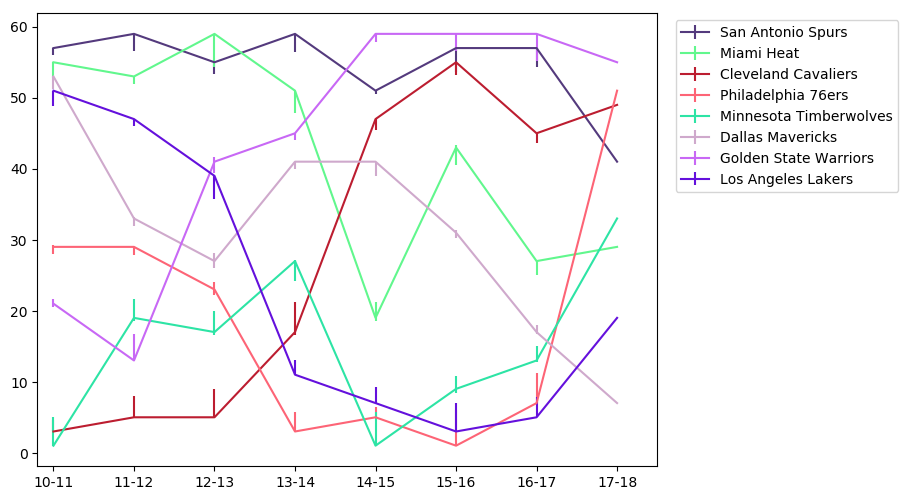

In [29]:
"""
   We will be using the error bar plot to indicate the error rate of win/lose prediction at certain time point.
   An easy way to understand this is, if the bar extends higher on the upper level (see Timberworlves 14-15 point), 
   the actual rate then is situated comparatively towards the bottom bond - standing for the error rate in predicting
   losing the game, in other words, the prediction of losing the game has a higher error rate - people who bet the 
   team to lose are likely wrong - so their had improve performance! And consequently, we see an increased trend for 
   Timberworlves at 15-16 season.
"""   
plot_accu(10, 17, 'Team_Stat_Accu.csv')

### Prediction in consideration of lineup changes

From the previous prediction results, we can see that there are still errors between the predicted results and actual results. Therefore, in the assumption that the changes to the line up of one team could have sigificant impact on the team preformance in the next season, we want to incorporate the line up changes into the original team performance features used in the previous prediction.

In order to do this, we need to extract the line up changes between two seasons and the advanced stats of the players who left and came into the team. The advanced stats include PER(efficiency), OWS(offensive win share), DWS(defensive win share), AGE(the age of player), VORP(value over replacement player), USG(Usage percentage).

The following codes are used to extract the change of lines up for one team on one specific year and construct the advanced stats for those players. 

In [30]:
# set up a connection with full team name and abbreviated team name

team_abbr_dict = {'Utah Jazz': 'UTA', 'Memphis Grizzlies': 'MEM', 'San Antonio Spurs': 'SAS',
        'Indiana Pacers': 'IND', 'Atlanta Hawks': 'ATL', 'Miami Heat': 'MIA',
        'Charlotte Hornets': 'CHO', 'Milwaukee Bucks': 'MIL', 'Chicago Bulls': 'CHI',
        'Washington Wizards': 'WAS', 'Portland Trail Blazers': 'POR',
        'New Orleans Pelicans': 'NOP', 'Cleveland Cavaliers': 'CLE', 'Detroit Pistons': 'DET',
        'Golden State Warriors': 'GSW', 'Los Angeles Clippers': 'LAC', 
        'Houston Rockets': 'HOU', 'Brooklyn Nets': 'BRK', 'Toronto Raptors': 'TOR',
        'Philadelphia 76ers': 'PHI', 'New York Knicks': 'NYK', 'Boston Celtics': 'BOS',
        'Orlando Magic': 'ORL', 'Oklahoma City Thunder': 'OKC', 'Dallas Mavericks': 'DAL',
        'Phoenix Suns': 'PHO', 'Denver Nuggets': 'DEN', 'Sacramento Kings': 'SAC',
        'Los Angeles Lakers': 'LAL', 'Minnesota Timberwolves': 'MIN' }

In [31]:
# get all player's advanced information of the given year
def get_all_players_per_year(year):
    """get the players advanced data for each year
        Args:
            (int) year : the year of the season
        Returns:
            dataframe contains all the players advanced data
    """
    df_list = [pd.read_csv("{}/{}_{}.csv".format('data/advanced', team_abbr_dict[team], year)).set_index("Name") for team in team_set]
    df = reduce(lambda x, y: x.append(y), df_list)
    return df

# create a feature based on the given year and given team
# the feature contains the gone team member (head 2) and new coming team member's stat, 
# together with the last year's elos value
def create_feature_per_year_per_team(year, team, all_player, player_mean, verbose=False):
    """create a feature based on the given year and given team,
       the feature contains the gone team member (head 2) and new coming team member's stat, 
       together with the last year's elos value
       Args:
           (int) year: the number of the year
           (String) team: the name of the team
           (dataframe): the dataframe contains all players' advanced data

    """
    columns = ['PER', 'OWS', 'DWS', 'AGE', 'VORP', 'USG']
    player_mean = player_mean[columns].values
    top_num = 2
    team_pre = pd.read_csv("{}/{}_{}.csv".format('data/advanced', team_abbr_dict[team], year)).set_index("Name")
    team_pos = pd.read_csv("{}/{}_{}.csv".format('data/advanced', team_abbr_dict[team], year + 1)).set_index("Name")
    gone_index = [i for i in team_pre.index if i not in team_pos.index]    # get the name list of the gone team members
    come_index = [i for i in team_pos.index if i not in team_pre.index]    # get the name list of the coming team members
    try:
        if verbose:
            print(team_pre.loc[gone_index])
            print(all_player.loc[come_index].sort_values(by=["MP"], ascending=False))

        # create features based on the gone member info
#         feature_gone = team_pre.loc[gone_index][columns].dropna().head(top_num).mean(axis = 0)
        feature_gone = team_pre.loc[gone_index][columns].dropna().head(top_num)
        
        # create features based on the come member info
        # the come member info is derived from the all_player dataframe
#         feature_come = all_player.loc[come_index].sort_values(by=["MP"], ascending=False).loc[:,columns].dropna().head(top_num).mean(axis=0)
        feature_come = all_player.loc[come_index].sort_values(by=["MP"], ascending=False).loc[:,columns].dropna().head(top_num)
        
        feature = feature_gone.append(feature_come).values
        feature = (feature - player_mean).flatten()

#         if len(feature) < len(columns) * 2:
#             feature = np.array([0] * len(columns) * 2)
        if len(feature) < len(columns) * 2 * top_num:
            feature = np.array(np.array([0] * len(columns) * 2 * top_num))
        return feature
    except:
        print(come_index)
#         return np.array([0] * len(columns) * 2)
        return np.array(np.array([0] * len(columns) * 2 * top_num))

def create_features_per_year(year):
    """create the features based on the given year
        Args:
            (int) year: the year for previous season and next season.
    """
    print("create players features for {}-{} and {}-{}".format(year-1, year, year, year+1))
    df = get_all_players_per_year(year)
    player_mean = df.mean(axis=0)
    X = dict([(team, create_feature_per_year_per_team(year, team, df, player_mean)) for team in team_set])
    return X

To verify that the changes of line ups and advanced stats are correctly constructed:

In [32]:
f = create_features_per_year(2014)
display(f)

create players features for 2013-2014 and 2014-2015


{'Atlanta Hawks': array([ 1.8689781 ,  0.41021898, -0.10218978,  0.52007299, -0.44963504,
         2.56478102, -1.4310219 , -0.78978102, -0.40218978,  2.52007299,
        -0.74963504, -0.83521898, -1.9310219 , -0.28978102,  0.99781022,
         2.52007299,  0.55036496, -6.43521898,  0.9689781 , -1.18978102,
        -0.70218978, -2.47992701, -0.44963504,  3.96478102]),
 'Boston Celtics': array([ 5.8689781 ,  1.11021898,  0.69781022,  1.52007299,  0.15036496,
         0.66478102,  3.3689781 ,  0.51021898, -0.40218978, -1.47992701,
        -0.04963504,  3.66478102,  8.1689781 ,  5.21021898,  0.19781022,
        -2.47992701,  2.55036496,  7.96478102,  1.5689781 ,  0.41021898,
         0.09781022,  4.52007299, -0.04963504,  1.76478102]),
 'Brooklyn Nets': array([ 4.4689781 ,  1.71021898,  1.19781022,  9.52007299,  1.25036496,
         4.06478102,  2.1689781 ,  1.41021898,  0.69781022,  1.52007299,
         0.75036496, -2.23521898,  4.2689781 ,  0.01021898,  1.19781022,
        -1.47992701, 

After the changes of lineups and advanced stats of those changed players are correctly constructed, we can re-write the predictor class to incorporate the lineup changes by simply adding the advanced stats into the trained data set and test data set.

It is important to note that we need the team performance stats from the previous as the training and test data set. The whole train and predict process is shown in the following picture:
<img src="explain.png" style="width:750px;height:400px">
Additionally, we don't train the model to get the elo_score. Instead, the elo_score will be directly read from the file. The codes for modified predictor is shown below:

In [33]:
class team_win_lose_adj_predictor: 
    """the adjusted predictor for team win-lose performance
    """
    def get_model(self, season_num):
        """train and cross validate the logistic regression using the team performance data
           incorporated with lineup changes.
           Args:
               (int) season_num: the season number
           Returns:
               (model) model: already trained logistic model
        """
        # get last year's stat
        last_season = "{}-{}".format(season_num - 1, season_num)
        Rstat = pd.read_csv(os.path.join('data', last_season, 'Result.csv'))
        elos = pd.read_csv("data/elos.csv", index_col=0).astype("int")
        self.last_team_stats = load_stat(last_season)
        
        # get elo score
        self.last_team_elos = elos[str(season_num - 1 + 2000)]
    
        # get all players' information
        year = season_num + 2000
        player_features = create_features_per_year(year)
        
        # create training features and result
        X, y = self.build_dataset(Rstat, player_features)
        print("Fitting on %d game samples.." % len(X))
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        
        print("Doing cross-validation..")
        print(cross_val_score(model, X, y, cv = 10, scoring='accuracy', n_jobs=-1).mean())
        
        return model
    

    def build_dataset(self, raw_data, player_features):
        """build the training dataset based on the raw data
           Args:
               (dataframe) raw_data: the team performance features
               (dict) player_features: the dict contains each team's line-up changes and associated advanced stats 
           Return:
               X the train data
               y the train data's labels
        """
        print("Building dataset ...")
        X = []
        y = []
        for index, row in raw_data.iterrows():
            Wteam = row['WTeam']
            Lteam = row['LTeam']
            # get the elos of the two teams
            team1_elo = self.last_team_elos.loc[Wteam]
            team2_elo = self.last_team_elos.loc[Lteam]
            # update the elo value
            if row['WLoc'] == 'H':
                team1_elo += 100
            else:
                team2_elo += 100
            # add elo value into the feature
            team1_features = [team1_elo]
            team2_features = [team2_elo]
            # add Tstat, Ostat and Mstat into the feature
            for key, value in self.last_team_stats.loc[Wteam].iteritems():
                team1_features.append(value)
            for key, value in self.last_team_stats.loc[Lteam].iteritems():
                team2_features.append(value)
            
            # add player info into the feature
            team1_features += player_features[Wteam].tolist()
            team2_features += player_features[Lteam].tolist()

            # randomize the feature and label
            if random.random() > 0.5:
                X.append(team1_features + team2_features + [1])
                y.append(0)
            else:
                X.append(team2_features + team1_features + [1])
                y.append(1)
        
        return np.nan_to_num(X), y
    
    def predict_winner(self, team_1, team_2, model, next_year_player_features):
        """predict the winner of a match
           Args:
               (String) team1: the name of the first team
               (String) team2: the name of the second team
               (Model) model: the logistic regression model
               (dict) next_year_player_features: the dictionary contains lineup changes for each team
           Returns:
                the probability of winning a match
        """
        features = []
        
        features.append(self.cur_team_elos.loc[team_1])
        for key, value in self.cur_team_stats.loc[team_1].iteritems():
            features.append(value)
        features += next_year_player_features[team_1].tolist()
        
        features.append(self.cur_team_elos.loc[team_2] + 100)
        for key, value in self.cur_team_stats.loc[team_2].iteritems():
            features.append(value)
        features += next_year_player_features[team_2].tolist()
        # add the bias
        features += [1]
        features = np.nan_to_num(features)        
        return model.predict_proba([features])
    
    # predict the win-lose relationship with the given schedule
    def predict_schedule(self, schedule, model, next_year_player_features):
        """Given schedule of the next season, predict all the match up results
           with a probablity.
           Args:
               (dataframe) schedule: the dataframe contains the schedule
               (model) model: the trained logistic regression model
               (dict) next_year_player_features: the dictionary contains lineup changes for each team
            Return:
                a list containing all predicted matched up results.
        """
        result = []
        for index, row in schedule.iterrows():
            team1 = row['Visitor/Neutral']
            team2 = row['Home/Neutral']
            pred = self.predict_winner(team1, team2, model, next_year_player_features)
            prob = pred[0][0]
            item = [team1, team2, prob] if prob > 0.5 else [team2, team1, 1 - prob]
            result.append(item)
        return result
    
    # run the predict
    def run(self, season_num):
        """the main function to run the training and prediction.
           Args:
               (int) season_num: the season number.
        """
        model = self.get_model(season_num)
        # get current year's stat
        cur_season = "{}-{}".format(season_num, season_num + 1)
        self.cur_team_stats = load_stat(cur_season)
        elos = pd.read_csv("data/elos.csv", index_col=0).astype("int")
        self.cur_team_elos = elos[str(season_num + 2000)]
        # get next_season's player info and schedule
        next_season = "{}-{}".format(season_num + 1, season_num + 2)
        next_year_player_features = create_features_per_year(season_num + 1 + 2000)
        schedule = pd.read_csv(os.path.join('data', next_season, 'Schedule.csv'))

        result = self.predict_schedule(schedule, model, next_year_player_features)

        with open(os.path.join('data', next_season, 'Pre_Result_Adj.csv'), 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['win', 'lose', 'probability'])
            writer.writerows(result)
            print('done.')
        
        check_accuracy(result, next_season, "Team_stat_Accu_Adj.csv")

After adjusting the predictor, we can set up the new predictor and run the model to see if there are any improvements compared with previous model.

In [34]:
predictor_adj = team_win_lose_adj_predictor()
for i in range(11, 17):
    print('-----------------')
    predictor_adj.run(i)
    print('-----------------')

-----------------
create team stat features for  10-11
create players features for 2010-2011 and 2011-2012
Building dataset ...
Fitting on 1230 game samples..
Doing cross-validation..
0.6990715541740293
create team stat features for  11-12
create players features for 2011-2012 and 2012-2013
['Nando De Colo', 'Aron Baynes']
done.
50.0 confidence:, total num: 63, error num: 34
error_rate:  0.5396825396825397
60.0 confidence:, total num: 103, error num: 61
error_rate:  0.5922330097087378
70.0 confidence:, total num: 220, error num: 113
error_rate:  0.5136363636363637
80.0 confidence:, total num: 383, error num: 144
error_rate:  0.37597911227154046
90.0 confidence:, total num: 460, error num: 110
error_rate:  0.2391304347826087
total error rate: 0.37591537835638733
Win Los delta avg: 9.066666666666666, var: 35.44367816091953
-----------------
-----------------
create team stat features for  11-12
create players features for 2011-2012 and 2012-2013
['Nando De Colo', 'Aron Baynes']
Building 

Use the same visualization functions defined in the first prediction to visualize the results from the second prediction.

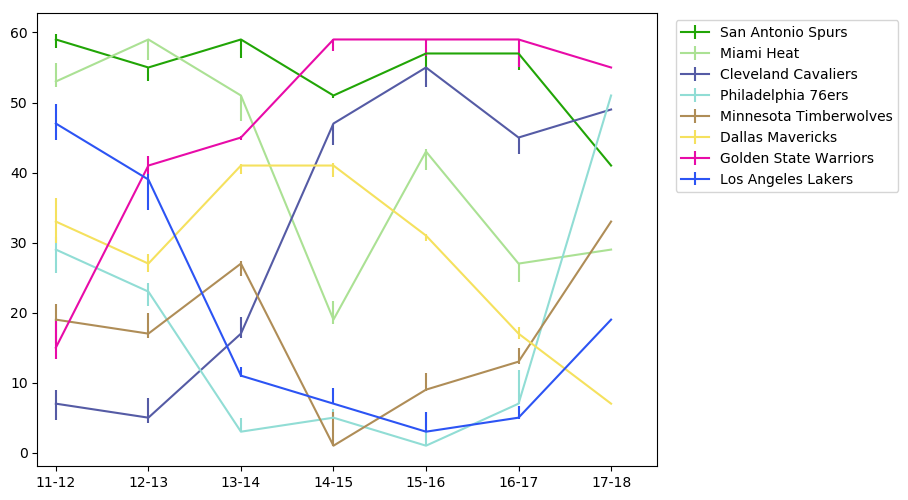

In [35]:
plot_accu(11, 17, 'Team_Stat_Accu_Adj.csv')

## Conclusion

Comparaing many aspects of the adjusted prediction model and the original model, there are some quick conclusions we can draw:
1. The total error rate: after the incoporation of the the major player's feature as an input into the original model, we did not see significant inprovement in reducing the error rate, as our sample are not focused on these four teams, we will expect the error rate won't differ much even apply the model to the whole NBA teams.
2. Reflections on the adjusted model: Although key players do have an impact on the total performance of certain teams, major players such as James LeBron and Kevin Love did radically changed the performance of a team. However, it is not enough to only add their features, some co-factors that are related to their performance, such as strategy changes, other team players change of features as a reponse to their existance also need to be reasonable assign a weight into the model to be trained. 
3. We do see some corrections of certain points in the model prediction result, this indicates that this first step of incorporating the player's features are taking effects, nevertheless, some more intensive analysis into the the side-effects of adding the features directly to the model are definitely well-worth attention as the next step. 